# Import Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Define the XOR Data Set

In [2]:

X = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [0, 1, 1],
    [0, 0, 1],
])

y = np.array([[0],
              [1],
              [1],
              [0]
             ])

In [3]:
X.shape[1]

3

# Define Parameters

In [4]:
# Number of epochs for learning
epochs = 1000

# Learning Rate
eta = 3

#Input layer
inputLayer = X.shape[1]

# Number of Hidden Neurons
hidden = 10

# Drop out rate probability (drp = 1 means no dropout)
drp = 0.5

# Define NN Class and Functions

In [5]:
class Neural_Network(object):
    def __init__(self, eta, inputL, hiddenL, drp):

        # Define NN structure parameters
        self.inputLayer = inputL
        self.hidden = hiddenL
        self.outputLayer = 1
        self.eta = eta
        self.drp = drp

        # Initialise random weights based on NN structure
        self.w01 = np.random.random((self.inputLayer, self.hidden))
        self.w12 = np.random.random((self.hidden, self.outputLayer))
        

        # Initialise Weights Learning lists to keep track of weights learning curve
        self.w01_list = []
        self.w12_list = []
        self.w01_curve = []
        self.w12_curve = []

        # Initialise Error list to keep track of Error learning curve
        self.E_o = []

    def feedforward(self,X,mode):
        # ****************************************************************************
        # Feedforward FUNCTION
        # 
        # Purpose of this function is to calculate the NN output based on the Input X,
        # the given Weights per layer and the activation function for each neuron. The
        # function is designed to cater for Dropout feature, which scales the weights
        # of the NN during Testing, by probability p, which is a parametrised using 
        # input variable k. Typical default dropout value is 0.5. For k=1 there is no 
        # dropout
        # 
        # Paramenters
        # X     :Input vector
        # mode  :Select "0" for Training Mode or Select "1" for Testing Mode
        # k     :Optional input for the Dropout Hyperparameter, when applicable. If not
        #        specified, it is defaulted to NN configuration

        # When training (mode="0") Drop out applies for the hidden layer outputs a_h
        if mode == 0:
            #print("Testing mode activated")
            self.z_h = np.dot(X, self.w01)
            a_h = self.sigmoid(self.z_h)
            
            # Dropout term: random noise added to input ah (output of the hidden layer 
            # but input to the output) with probability "p"
            r = np.random.binomial(size=a_h.shape,n=1,p=self.drp)
            a_h *= r
            
            self.z_o = np.dot(a_h, self.w12)
            a_o = self.sigmoid(self.z_o)

        # When Testing (mode = "1") we use the normal weights w12 (not scaled with p)
        elif mode == 1:
            #print("Training mode activated")
            self.z_h = np.dot(X, self.w01)
            a_h = self.sigmoid(self.z_h)
            self.z_o = np.dot(a_h, self.w12)
            a_o = self.sigmoid(self.z_o)

        return(a_o,a_h)


    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))


    def backprop(self,X,y,a_o,a_h):
        # Backpropagation
        ## Output to Hidden Layer weights
        self.delta_E_o = a_o - y
        self.delta_a_o = self.sigmoid(a_o,derivative=True)
        self.delta_z_o = a_h
        self.delta_E_w12 = np.dot(self.delta_z_o.T,(self.delta_E_o * self.delta_a_o))

        ## Hidden to Input Layer weights
        self.delta_E_h = np.dot(self.delta_E_o * self.delta_a_o, self.w12.T)
        self.delta_a_h = self.sigmoid(a_h,derivative=True)
        self.delta_z_h = X
        self.delta_E_w01 = np.dot(self.delta_z_h.T, self.delta_E_h * self.delta_a_h)

        # Store All weights throughout learning
        self.w01_list.append(self.w01)
        self.w12_list.append(self.w12)

        # Adjust weights
        self.w01 = self.w01 - eta * self.delta_E_w01
        self.w12 = self.w12 - eta * self.delta_E_w12

        
    def saveWeights(self):
        np.savetxt("w1.txt", self.w01, fmt="%s")
        np.savetxt("w2.txt", self.w12, fmt="%s")
        # print("Input-Hidden Layer weights:\n",self.w01)
        # print("\nHidden-Output Layer weights:\n",self.w12)

    def weightsCurve(self):
        for i in range(self.w01.shape[0]):
            for j in range(self.w01.shape[1]):
                for x in range(len(self.w01_list)):
                    self.w01_curve.append(self.w01_list[x][i][j])
                    #print("Weights w[",x,"],[",i,"],[",j,"] stored")
                    #print(w01_list[x][i][j])

    def error(a_o_error, y):
        a_o_error = ((1 / 2) * (np.power((a_o - y), 2)))
        return a_o_error
    
    def errorCurve(self, a_o_error):
        self.E_o = np.append(self.E_o, sum(a_o_error))
        return self.E_o
    
    def train(self,X,y):
        a_o, a_h = self.feedforward(X,0)
        self.backprop(X,y,a_o,a_h)

    def plot(self, E_o):
        fig = plt.figure()
        plt.plot(E_o)
        if self.drp == 1:
            fig.suptitle('Error', fontsize=16)
        elif self.drp == 0.5:
            fig.suptitle('Error with Dropout', fontsize=16)
        
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Error achieved', fontsize=12)
        if self.drp == 1:
            fig.savefig('Error.jpg')
        elif self.drp == 0.5:
            fig.savefig('Error with Dropout.jpg')
        
        plt.show()

    def predict(self, X):
        a_o, a_h = self.feedforward(X,1)
        print("Minimum Error achieved:", min(self.E_o)) 
        print("Epochs run:", epochs)
        print("Hidden neurons",self.hidden)
        print("Learning Rate:",self.eta)
        #np.savetxt("Predicted_Output.csv", a_o, delimiter=",")
        print("\nPredicted Output based on trained weights:")
        print(a_o)
        print("\n")
        
    def plotWeights(self, epochs):
        fig = plt.figure()
        numberOfWeights = self.w01.shape[1]*self.w01.shape[0]
        for k in range(numberOfWeights):
            t= self.w01_curve[(epochs*k):(epochs*(k+1)-1)]
            plt.plot(t)

        if self.drp == 1:
            fig.suptitle('W01 Weights learning', fontsize=16)
        elif self.drp == 0.5:
            fig.suptitle('W01 Weights learning WITH dropout', fontsize=16)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('W01', fontsize=12)
        #fig.savefig('W01_curve.jpg')

In [6]:
# Alternative implementation for Masking drop out feature

#test = np.random.rand(*a_h.shape) < drp
#test.shape
#a_h*test

## Start feeding forward and backpropagate *epochs* times.

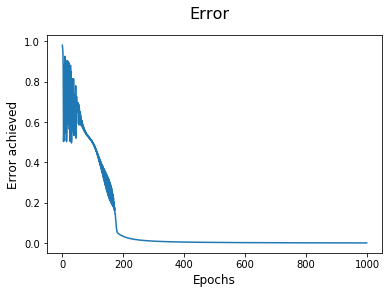

Minimum Error achieved: 0.0012398435920706733
Epochs run: 1000
Hidden neurons 15
Learning Rate: 5

Predicted Output based on trained weights:
[[0.02333097]
 [0.97646238]
 [0.97631209]
 [0.02857832]]




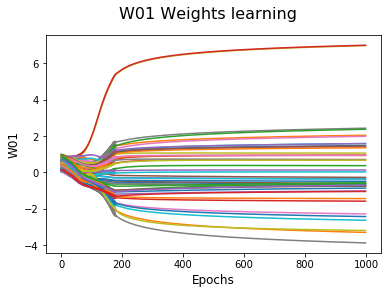

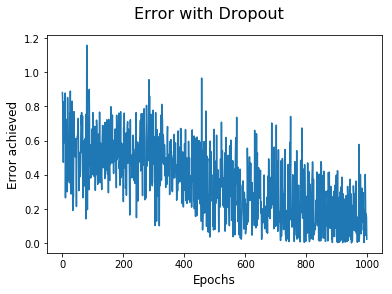

Minimum Error achieved: 0.0021306236502265092
Epochs run: 1000
Hidden neurons 15
Learning Rate: 5

Predicted Output based on trained weights:
[[0.02457648]
 [0.99594725]
 [0.99367613]
 [0.00402265]]




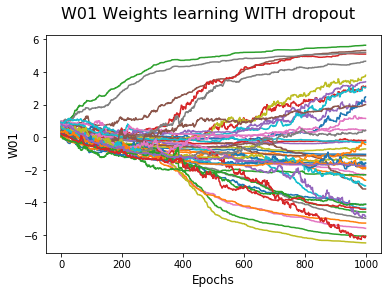

In [7]:

# Initiating 2 NNs with the following function and input parameters
# Neural_Network(eta, hidden, drp)

# Neural Network without Dropout
NN = Neural_Network(5,inputLayer, 15, 1)

# Neural Network with Dropout
NN1 = Neural_Network(5,inputLayer, 15, 0.5)

for epoch in range(epochs):
    #Forward pass
    a_o, a_h  = NN.feedforward(X,0)
    b_o, b_h  = NN1.feedforward(X,0)
    
    # Calculate the error
    a_o_error = ((1 / 2) * (np.power((a_o - y), 2)))
    b_o_error = ((1 / 2) * (np.power((b_o - y), 2)))
    
    # Build error curve while learning
    E_o = NN.errorCurve(a_o_error)
    E_o_1 = NN1.errorCurve(b_o_error)
    E = [E_o, E_o_1]
    
    # Train Neural Networks and construct weights learning curve as it learns
    NN.train(X, y)
    NN.weightsCurve

    NN1.train(X, y)
    NN1.weightsCurve

# Neural Network without Dropout
# Run prediction based on learned weights and Plot Error curve
NN.plot(E_o)
NN.predict(X)

# Build Weights curve using wxx_list and plot weights
NN.weightsCurve()
NN.plotWeights(epochs)

# Neural Network WITH Dropout
NN1.plot(E_o_1)
NN1.predict(X)

# Build Weights curve using wxx_list and plot weights
NN1.weightsCurve()
NN1.plotWeights(epochs)


# Save ALL Weights used for prediction
NN.saveWeights()
NN1.saveWeights()




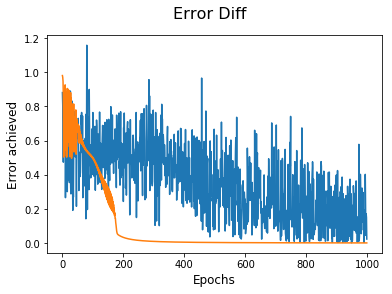

In [8]:
fig = plt.figure()
plt.plot(E_o_1)
plt.plot(E_o)
fig.suptitle('Error Diff', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error achieved', fontsize=12)
fig.savefig('Error Diff.jpg')
plt.show()
